In [32]:
# Define the data directory

# data_dir = 'data/mnist/'
# save_dir = os.path.join(data_dir, 'invert')

# # Create directories if they don't exist
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to the range [0, 1] (not [-1, 1] for inversion purposes)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Expand dimensions to match the shape (-1, 28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Invert the images (0 becomes 1, and 1 becomes 0)
invert_x_train = 1.0 - x_train
invert_x_test = 1.0 - x_test

# # Save the inverted images
# np.save(os.path.join(save_dir, 'train_images_invert.npy'), invert_x_train)
# np.save(os.path.join(save_dir, 'test_images_invert.npy'), invert_x_test)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

print("Inverted images and saved successfully.")

Inverted images and saved successfully.


## Improt requirment library

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

## Load data

In [34]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to the range [0, 1] (not [-1, 1] for inversion purposes)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Expand dimensions to match the shape (-1, 28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Invert the images (0 becomes 1, and 1 becomes 0)
invert_x_train = 1.0 - x_train
invert_x_test = 1.0 - x_test

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

### Plot training data and invert training data

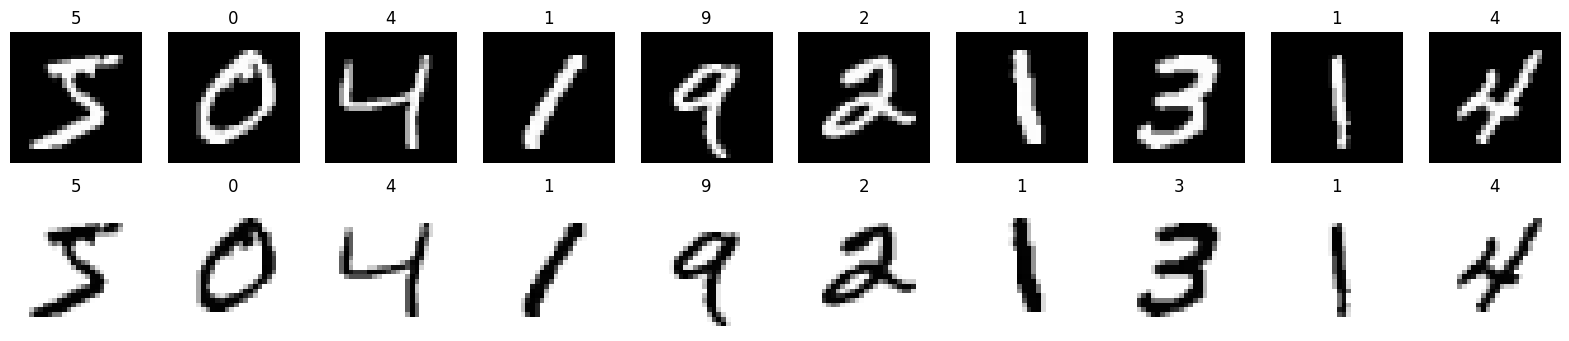

In [36]:
# Plot 10 images from x_train and their corresponding labels from y_train
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original images
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
    
    # Inverted images
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(invert_x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

## Implementation

参数重用 (Reuse)：

重用的是子模型或模块。这意味着整个子模型（包括其所有层和参数）在不同的地方被多次使用。
这种方法通常用于需要在多个位置使用相同结构和权重的场景，如在不同分支中重复使用相同的子网络。
参数共享 (Parameter Sharing)：

共享的是模型中的层。这意味着特定的层（包括其权重）在不同的模型或模型的不同部分之间共享。
这种方法用于在同一个模型的不同部分或不同模型之间共享权重，以减少参数数量和提高训练效率。

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model

# 定义一个简单的子模型，可以在不同地方重用
def build_sub_model(gfc_dim, gf_dim, s4):
    inputs = Input(shape=(100,))
    h0 = Dense(gfc_dim)(inputs)
    h0 = BatchNormalization()(h0)
    h0 = LeakyReLU()(h0)

    h1 = Dense(gf_dim * 2 * s4 * s4)(h0)
    h1 = BatchNormalization()(h1)
    h1 = LeakyReLU()(h1)
    h1 = Reshape((s4, s4, gf_dim * 2))(h1)
    
    return Model(inputs, h1, name='sub_model')

# 使用子模型重用
def generator_with_reuse(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G'):
    s = output_size
    s2, s4 = int(s / 2), int(s / 4)

    # 定义主模型输入
    z = Input(shape=(z_dim,))
    
    # 重用子模型
    sub_model = build_sub_model(gfc_dim, gf_dim, s4)
    h1 = sub_model(z)
    
    h2 = Conv2DTranspose(gf_dim * 2, kernel_size=4, strides=2, padding='same')(h1)
    h2 = BatchNormalization()(h2)
    h2 = LeakyReLU()(h2)
    
    # 输出层
    output = Conv2DTranspose(c_dim, kernel_size=4, strides=2, padding='same')(h2)
    output = tf.keras.activations.sigmoid(output)
    
    # 创建模型
    model = Model(inputs=z, outputs=output, name=name)
    
    return model

# 示例使用
z_dim = 100
output_size = 64
gfc_dim = 1024
gf_dim = 64
c_dim = 3
batch_size = 64

gen_model1 = generator_with_reuse(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G1')
gen_model2 = generator_with_reuse(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G2')
gen_model1.summary()
gen_model2.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model

# 全局定义共享层
shared_dense1 = Dense(1024)
shared_dense2 = Dense(64 * 2 * (64 // 4) * (64 // 4))
shared_bn0 = BatchNormalization()
shared_bn1 = BatchNormalization()
shared_bn2 = BatchNormalization()
shared_conv2d_t1 = Conv2DTranspose(64 * 2, kernel_size=4, strides=2, padding='same')
shared_conv2d_t2 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')

def generator_with_sharing(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G'):
    s = output_size
    s2, s4 = int(s / 2), int(s / 4)

    # 输入层
    z = Input(shape=(z_dim,))

    # 共享层
    h0 = shared_dense1(z)
    h0 = shared_bn0(h0, training=True)
    h0 = LeakyReLU()(h0)

    h1 = shared_dense2(h0)
    h1 = shared_bn1(h1, training=True)
    h1 = LeakyReLU()(h1)
    h1 = Reshape((s4, s4, gf_dim * 2))(h1)

    h2 = shared_conv2d_t1(h1)
    h2 = shared_bn2(h2, training=True)
    h2 = LeakyReLU()(h2)

    # 输出层
    output = shared_conv2d_t2(h2)
    output = tf.keras.activations.sigmoid(output)

    # 创建模型
    model = Model(inputs=z, outputs=output, name=name)

    return model

# 示例使用
z_dim = 100
output_size = 64
gfc_dim = 1024
gf_dim = 64
c_dim = 3
batch_size = 64

gen_model1 = generator_with_sharing(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G1')
gen_model2 = generator_with_sharing(z_dim, output_size, gfc_dim, gf_dim, c_dim, batch_size, name='G2')
gen_model1.summary()
gen_model2.summary()


In [ ]:
def prelu(x, name):
    alpha = tf.Variable(tf.zeros(x.shape[-1]), name=name + '_alpha')
    return tf.maximum(0.0, x) + alpha * tf.minimum(0.0, x)

PReLU(x)=max(0,x)+α⋅min(0,x)

it is a relu active function with parameter term

### Generator

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, Model


# share the weight

g_h0 = layers.Dense(gfc_dim, name='g_h0_lin')
g_h0 = layers.BatchNormalization()

g_h1 = layers.Dense(gf_dim * 2 * s4 * s4, name='g_h1_lin')
g_h1 = layers.BatchNormalization()

g_h2 = layers.Conv2DTranspose(gf_dim * 2, kernel_size=4, strides=2, padding='same', name='g_h2')
g_h2 = layers.BatchNormalization()


def build_generator(z_dim, output_size, gf_dim, gfc_dim, branch):
    def prelu(x, name):
        alpha = tf.Variable(tf.zeros(x.shape[-1]), name=name+'_alpha')
        return tf.maximum(alpha * x, x)
    
    s2, s4 = int(output_size / 2), int(output_size / 4)
    inputs = layers.Input(shape=(z_dim,))
    
    h0 = g_h0(inputs)
    h0 = g_h0(h0)
    h0 = prelu(h0, name='g_h0_prelu')

    h1 = g_h1(h0)
    h1 = g_h1(h1)
    h1 = prelu(h1, name='g_h1_prelu')
    h1 = layers.Reshape((s4, s4, gf_dim * 2))(h1)

    h2 = g_h2(h1)
    h2 = g_h2(h2)
    h2 = prelu(h2, name='g_h2_prelu')

    h3 = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', name=f'g{branch}_h3')(h2)
    output = tf.nn.sigmoid(h3)

    model = Model(inputs, output)
    return model, model(inputs)

### Discrminator

In [59]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_discriminator(input_shape, df_dim, dfc_dim, branch):
    def prelu(x, name):
        alpha = tf.Variable(tf.zeros(x.shape[-1]), name=name+'_alpha')
        return tf.maximum(alpha * x, x)
    
    inputs = layers.Input(shape=input_shape)
    h0 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same', name=f'd{branch}_h0_conv')(inputs)
    h0 = prelu(h0, name=f'd{branch}_h0_prelu')

    h1 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same', name=f'd{branch}_h1_conv')(h0)
    h1 = layers.BatchNormalization(axis=-1)(h1)  # BatchNormalization over the channels axis
    h1 = prelu(h1, name=f'd{branch}_h1_prelu')
    h1 = layers.Flatten()(h1)

    h2 = layers.Dense(dfc_dim, name=f'd{branch}_h2_lin')(h1)
    h2 = layers.BatchNormalization()(h2)  # Dense layer, axis default (last axis) is fine
    h2 = prelu(h2, name=f'd{branch}_h2_prelu')

    h3 = layers.Dense(1, name=f'd{branch}_h3_lin')(h2)

    model = Model(inputs, tf.nn.sigmoid(h3))
    return model, model(inputs), h3

### Build model

In [55]:
z_dim = 100
gf_dim = 64
df_dim = 64
gfc_dim = 1024
dfc_dim = 1024
c_dim = 3

In [42]:
epoch = 25
learning_rate = 0.0002
beta1 = 0.5
train_size = np.inf
batch_size = 128
output_size = 64

In [43]:
# Shuffle datasets
# data_X1 is the original image
# data_X2 is the black-white image
idx = np.arange(len(y_train_one_hot))
np.random.shuffle(idx)
data_X1, data_y1 = x_train[idx], y_train_one_hot[idx]
np.random.shuffle(idx)
data_X2, data_y2 = invert_x_train[idx], y_train_one_hot[idx]

In [47]:
# sample noise
sample_z = np.random.normal(size=(batch_size , z_dim))
sample_images1 = data_X1[0:batch_size]
sample_images2 = data_X2[0:batch_size]
sample_labels1 = data_y1[0:batch_size]
sample_labels2 = data_y2[0:batch_size]

In [49]:
sample_images1.shape

(128, 28, 28, 1)

In [53]:
G1, G1_model = build_generator(z_dim, output_size, gf_dim, gfc_dim, '1')

In [57]:
G2, G2_model = build_generator(z_dim, output_size, gf_dim, gfc_dim, '2')

In [60]:
D1, D1_logits, D1_h3 = build_discriminator([output_size, output_size, c_dim], df_dim, dfc_dim, '1')

In [61]:
D1, D1_logits, D1_h3 = build_discriminator([output_size, output_size, c_dim], df_dim, dfc_dim, '1')

In [16]:
import os
import time
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, Model

# from ops import *
# from utils import *




def load_mnist(dataset_name):
    data_dir = os.path.join("./data", dataset_name)

    fd = open(os.path.join(data_dir, 'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)

    fd = open(os.path.join(data_dir, 'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000)).astype(np.float)

    fd = open(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)

    fd = open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000)).astype(np.float)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, int(y[i])] = 1.0

    return X / 255., y_vec

def load_invert_mnist(dataset_name):
    data_dir = os.path.join(os.path.join("./data", dataset_name, 'invert'))

    trX = np.load(os.path.join(data_dir, 'train-images-idx3-ubyte.npy'))
    teX = np.load(os.path.join(data_dir, 't10k-images-idx3-ubyte.npy'))

    X = np.concatenate((trX, teX), axis=0)
    return X / 255.

def train(config):
    # Load datasets
    data_X1, data_y = load_mnist(config.dataset_name)
    data_X2 = load_invert_mnist(config.dataset_name)

    # Shuffle datasets
    idx = np.arange(len(data_y))
    np.random.shuffle(idx)
    data_X1, data_y1 = data_X1[idx], data_y[idx]
    np.random.shuffle(idx)
    data_X2, data_y2 = data_X2[idx], data_y[idx]

    # Initialize models and optimizers
    g_bn0, g_bn1, g_bn2 = layers.BatchNormalization(), layers.BatchNormalization(), layers.BatchNormalization()
    d1_bn1, d2_bn1, d_bn2 = layers.BatchNormalization(), layers.BatchNormalization(), layers.BatchNormalization()

    G1, G1_model = build_generator(config.z_dim, config.output_size, config.gf_dim, config.gfc_dim, '1', g_bn0, g_bn1, g_bn2)
    G2, G2_model = build_generator(config.z_dim, config.output_size, config.gf_dim, config.gfc_dim, '2', g_bn0, g_bn1, g_bn2)
    D1, D1_logits, D1_h3 = build_discriminator([config.output_size, config.output_size, config.c_dim], config.df_dim, config.dfc_dim, '1', d1_bn1, d_bn2)
    D2, D2_logits, D2_h3 = build_discriminator([config.output_size, config.output_size, config.c_dim], config.df_dim, config.dfc_dim, '2', d2_bn1, d_bn2)

    d_optim = tf.keras.optimizers.Adam(config.learning_rate, beta_1=config.beta1)
    g_optim = tf.keras.optimizers.Adam(config.learning_rate, beta_1=config.beta1)

    @tf.function
    def compute_loss(d_real_logits, d_fake_logits):
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits) * 0.9))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits) * 0.1))
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits) * 0.9))
        return d_loss_real + d_loss_fake, g_loss

    sample_z = np.random.normal(size=(config.batch_size, config.z_dim))
    sample_images1 = data_X1[:config.batch_size]
    sample_images2 = data_X2[:config.batch_size]
    sample_labels1 = data_y1[:config.batch_size]
    sample_labels2 = data_y2[:config.batch_size]

    counter = 1
    start_time = time.time()

    for epoch in range(config.epoch):
        batch_idxs = min(len(data_X1), config.train_size) // config.batch_size

        for idx in range(batch_idxs):
            batch_images1 = data_X1[idx*config.batch_size:(idx+1)*config.batch_size]
            batch_images2 = data_X2[idx*config.batch_size:(idx+1)*config.batch_size]
            batch_labels1 = data_y1[idx*config.batch_size:(idx+1)*config.batch_size]
            batch_labels2 = data_y2[idx*config.batch_size:(idx+1)*config.batch_size]
            batch_z = np.random.normal(size=[config.batch_size, config.z_dim]).astype(np.float32)

            with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
                D1_real_logits, D1_real_h3 = D1(batch_images1)
                D2_real_logits, D2_real_h3 = D2(batch_images2)
                G1_fake_images = G1(batch_z)
                G2_fake_images = G2(batch_z)
                D1_fake_logits, D1_fake_h3 = D1(G1_fake_images)
                D2_fake_logits, D2_fake_h3 = D2(G2_fake_images)

                d_loss, g_loss = compute_loss(D1_real_logits, D1_fake_logits)
                d_loss2, g_loss2 = compute_loss(D2_real_logits, D2_fake_logits)

            d_gradients = d_tape.gradient(d_loss + d_loss2, D1.trainable_variables + D2.trainable_variables)
            g_gradients = g_tape.gradient(g_loss + g_loss2, G1.trainable_variables + G2.trainable_variables)

            d_optim.apply_gradients(zip(d_gradients, D1.trainable_variables + D2.trainable_variables))
            g_optim.apply_gradients(zip(g_gradients, G1.trainable_variables + G2.trainable_variables))

            errD = (d_loss + d_loss2).numpy()
            errG = (g_loss + g_loss2).numpy()
            counter += 1
            print(f"Epoch: [{epoch}] [{idx}/{batch_idxs}] time: {time.time() - start_time}, d_loss: {errD:.8f}, g_loss: {errG:.8f}")

def evaluate():
    pass

def main():
    config = {
        'epoch': 25,
        'learning_rate': 0.0002,
        'beta1': 0.5,
        'train_size': np.inf,
        'batch_size': 128,
        'output_size': 64,
        'c_dim': 3,
        'dataset_name': 'mnist',
        'checkpoint_dir': 'checkpoint',
        'sample_dir': 'samples',
        'z_dim': 100,
        'gf_dim': 64,
        'df_dim': 64,
        'gfc_dim': 1024,
        'dfc_dim': 1024
    }
    if not os.path.exists(config['checkpoint_dir']):
        os.makedirs(config['checkpoint_dir'])
    if not os.path.exists(config['sample_dir']):
        os.makedirs(config['sample_dir'])
    
    train(config)

if __name__ == '__main__':
    main()


AttributeError: 'dict' object has no attribute 'dataset_name'